In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [38]:
df = pd.read_csv("optionData.csv")
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26397 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SeInstructionId     26397 non-null  int64  
 1   OrderId             26397 non-null  int64  
 2   TimeSe              26397 non-null  object 
 3   OptionId            26397 non-null  int64  
 4   UnderlyingSymbol    26397 non-null  object 
 5   Expiration          26397 non-null  object 
 6   Strike              26397 non-null  float64
 7   CallPut             26397 non-null  object 
 8   Side                26397 non-null  object 
 9   Size                26397 non-null  int64  
 10  Price               26397 non-null  float64
 11  Exchange            26397 non-null  object 
 12  MarketSize          26397 non-null  int64  
 13  TimeOmOut           26397 non-null  object 
 14  OrderEventType      26397 non-null  object 
 15  TimeOmIn            26397 non-null  object 
 16  Opti

In [39]:
#split data into Filled and Non Filled, orders rejected by SE are ommitted from following data sets 
def split(df, target):
    df1 = df[df[target] == "FILL"]
    df2 = df[df[target] == "CANCEL"]
    return df1, df2
filled, nonfilled= split(df, 'OrderEventTypeOmIn')
len(nonfilled)/ (len(filled) + len(nonfilled)) 
#55% of all processed orders are cancelled

0.5590408000909194

| Variable Name | Definition | 
| :- | :- |
| SEInstruction ID | Strategy Engine ID |
| OrderID | Order ID |
| TimeSE | Time Strategy Engine Makes Order |
| OptionID | Option ID|
| UnderlyingSymbol | Stock |
| Expiration | Expiration |
| Strike | Strike  |
| CallPut | Call or Put |
| Side | Buy or Sell |
| Size | Size of Order |
| Price | Price |
| Exchange | Exchange Order is Place |
| TimeOmOut | Time OM Recieves Order |
| OrderEventType | Reject or New |
| TimeOMin | Time OM Send Over |
| OptionIdOmin | OptionID |
| OrderEventType | Filled or Cancelled |


In [56]:
def formatTime(time):
    x = time.split(" ")[1].split(":")[2]
    return x
timeOut = pd.to_numeric(df["TimeOmOut"].apply(lambda x: formatTime(x)))
timeIn = pd.to_numeric(df["TimeOmIn"].apply(lambda x: formatTime(x)))
df["Time"] = timeIn - timeOut
def timeOfOrder(time):
    x = time.split(" ")[1].split(":")[0] + time.split(" ")[1].split(":")[1]
    x = pd.to_numeric(x)
    return x
df["TimeOfOrder"] = (df["TimeOmOut"].apply(lambda x: timeOfOrder(x)))


## Improving our Fill Rate
For this end of the report, we need to look for variables that might contribute to a higher or lower fill rate. Some factors that might contribute to this is the exchange the stock is sold in, the stock that is being traded and the size of the order itself. Here, I will begin analyzing how these factors influence the fill rate and potentially build a better strategy. 

In [59]:
#one hot encoding features
df1 = df
categorical_features = ["UnderlyingSymbol", "CallPut", "Side", "Exchange", "OrderEventTypeOmIn"]
for feature in categorical_features:
    df1[feature] = df1[feature].astype('category')
    one_hot = pd.get_dummies(df[feature])
    df1 = df1.drop(feature, axis = 1)
    df1 = df1.join(one_hot)
df1 = df1.drop("SeInstructionId", axis = 1)
df1 = df1.drop("OrderId", axis = 1)
df1 = df1.drop( "OptionId", axis = 1)
df1 = df1.drop("OptionIdOmIn", axis = 1)
df1.corr(method = "pearson")

/var/folders/pk/vjdnd39913sgqxdcnpt9gxc00000gn/T/ipykernel_14256/1240392541.py:13: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,Strike,Size,Price,MarketSize,Time,TimeOfOrder,AAPL,AMD,AMZN,BABA,...,C,P,B,S,AMEX,CBOE,ISE,PHLX,CANCEL,FILL
Strike,1.000000,-0.178323,0.547318,-0.212931,0.008402,-0.017089,-0.094061,-0.103475,0.730269,-0.083021,...,-0.006807,0.006807,-0.003816,0.003816,0.000774,-0.004159,-0.009056,0.012441,0.011663,-0.011663
Size,-0.178323,1.000000,-0.111529,0.848815,0.007158,0.012327,-0.003180,-0.020356,-0.087640,-0.031200,...,0.025781,-0.025781,0.001416,-0.001416,0.013079,-0.000200,-0.002949,-0.010014,0.078869,-0.078869
Price,0.547318,-0.111529,1.000000,-0.133468,0.001500,-0.012304,-0.057654,-0.055147,0.378968,-0.022587,...,-0.036586,0.036586,0.000634,-0.000634,-0.007910,-0.005452,-0.001978,0.015394,0.037585,-0.037585
MarketSize,-0.212931,0.848815,-0.133468,1.000000,0.002162,0.011280,-0.001555,-0.022661,-0.104731,-0.038463,...,0.035968,-0.035968,-0.002144,0.002144,0.007286,0.008672,-0.007390,-0.008617,0.009965,-0.009965
Time,0.008402,0.007158,0.001500,0.002162,1.000000,0.003210,-0.004332,-0.008080,0.009458,-0.001280,...,0.012676,-0.012676,-0.004709,0.004709,0.812543,-0.547048,-0.546899,0.276576,-0.033463,0.033463
TimeOfOrder,-0.017089,0.012327,-0.012304,0.011280,0.003210,1.000000,0.006888,0.006997,-0.012715,0.007338,...,0.001338,-0.001338,-0.010229,0.010229,0.002356,-0.005068,0.001477,0.001223,-0.012046,0.012046
AAPL,-0.094061,-0.003180,-0.057654,-0.001555,-0.004332,0.006888,1.000000,-0.047438,-0.048120,-0.047083,...,-0.005678,0.005678,-0.006608,0.006608,-0.001865,0.004185,0.001736,-0.004047,0.001771,-0.001771
AMD,-0.103475,-0.020356,-0.055147,-0.022661,-0.008080,0.006997,-0.047438,1.000000,-0.048057,-0.047021,...,0.006523,-0.006523,0.001228,-0.001228,-0.008253,0.009985,-0.002164,0.000481,0.006060,-0.006060
AMZN,0.730269,-0.087640,0.378968,-0.104731,0.009458,-0.012715,-0.048120,-0.048057,1.000000,-0.047698,...,-0.009490,0.009490,0.000976,-0.000976,0.004111,-0.005214,-0.007635,0.008716,0.017779,-0.017779
BABA,-0.083021,-0.031200,-0.022587,-0.038463,-0.001280,0.007338,-0.047083,-0.047021,-0.047698,1.000000,...,-0.006145,0.006145,-0.002956,0.002956,0.004056,-0.004278,0.008957,-0.008762,-0.000366,0.000366


The table above is a correlation table using the pearson method, which provides correlations between every variable within the table. Here, we are predominantly looking at whether the variable "FILL" is correlated. The values are all really small so we are going to look at correlations relatively large to anything the the table, so values that are above 1% are generally going to be worth analyzing within this matrix.

In [60]:
print(f"{df.Time.mean():.5f}")
exchanges = df.Exchange.unique()
for exchange in exchanges: 
    y = df.loc[df["Exchange"] == exchange]
    filled, nonfilled = split(y, 'OrderEventTypeOmIn')
    print(f"{exchange} had a fill rate of {(len(filled)*100/len(y)):.2f}% and an average latency of {y.Time.mean():.5f} seconds")


0.00068
PHLX had a fill rate of 55.14% and an average latency of 0.00100 seconds
CBOE had a fill rate of 40.88% and an average latency of 0.00006 seconds
AMEX had a fill rate of 40.29% and an average latency of 0.00160 seconds
ISE had a fill rate of 40.16% and an average latency of 0.00006 seconds


Given that exchange had relatively high correlation values(-0.044708, -0.037304, -0.045648, 0.127983), I chose to analyze their correlation with the fill rate.

In [61]:
x = df.Exchange.unique()
a = 0
exchange_data = np.array([[0,0], [0,0], [0,0], [0,0]])
for exchange in x:
    y = df.loc[df["Exchange"] == exchange]
    filled, nonfilled = split(y, 'OrderEventTypeOmIn')
    exchange_data[a] = np.array([len(filled), len(nonfilled)])
    a+=1

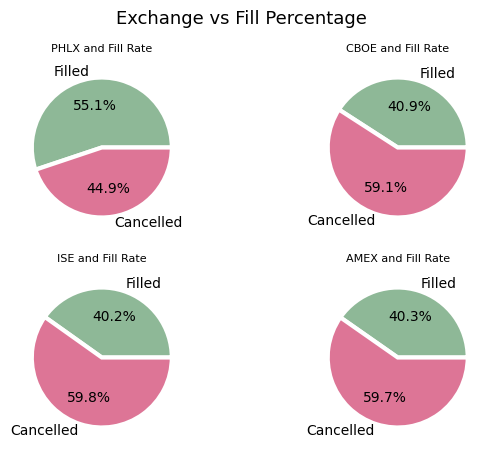

In [62]:
fig, axs = plt.subplots(2,2,figsize=(7,5)) #ax1,ax2 refer to your two pies
fig.suptitle('Exchange vs Fill Percentage', fontsize=13)
fig.patch.set_facecolor('white')

colors = ['#8EB897', '#DD7596']
labels = ["Filled", "Cancelled"]
axs[0][0].pie(exchange_data[0], colors = colors, autopct = '%1.1f%%', labels = labels, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }) 
axs[0][0].set_title(f'{x[0]} and Fill Rate', fontsize=8)

axs[0][1].pie(exchange_data[1], colors = colors, autopct = '%1.1f%%', labels = labels, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }) 
axs[0][1].set_title(f'{x[1]} and Fill Rate', fontsize=8)

axs[1][1].pie(exchange_data[2], colors = colors, autopct = '%1.1f%%', labels = labels, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }) 
axs[1][1].set_title(f'{x[2]} and Fill Rate', fontsize=8)

axs[1][0].pie(exchange_data[3], colors = colors, autopct = '%1.1f%%', labels = labels, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }) 
axs[1][0].set_title(f'{x[3]} and Fill Rate', fontsize=8)

plt.show()



Next thing I wanted to analyze was whether how the size of the order impacted the fill rate. This was backed by the correlation table

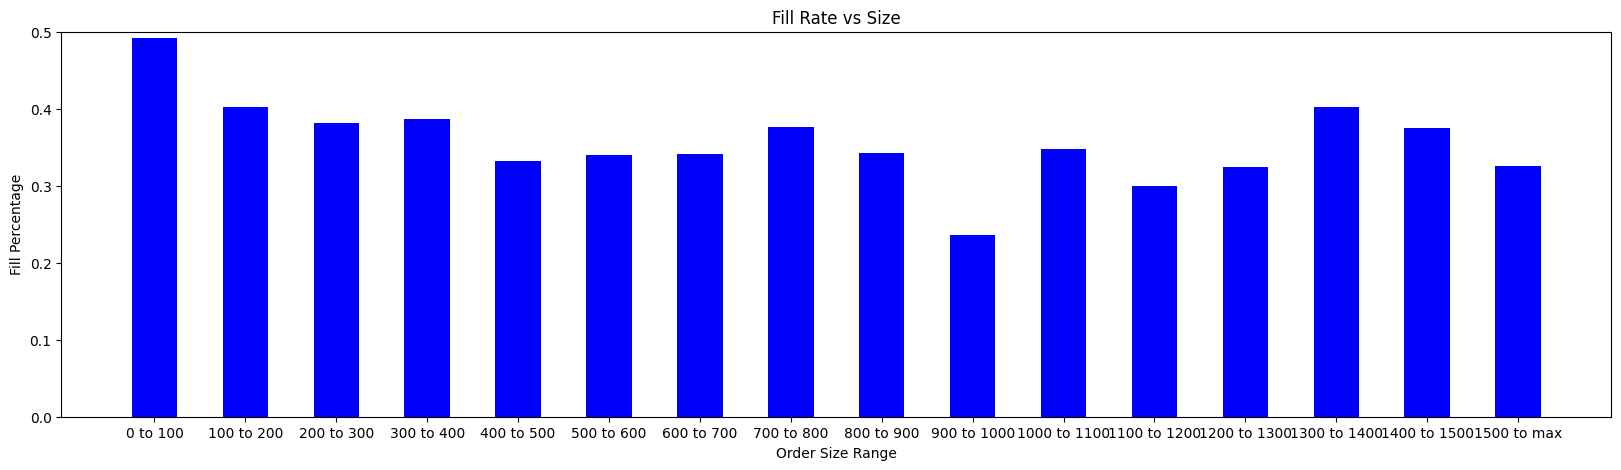

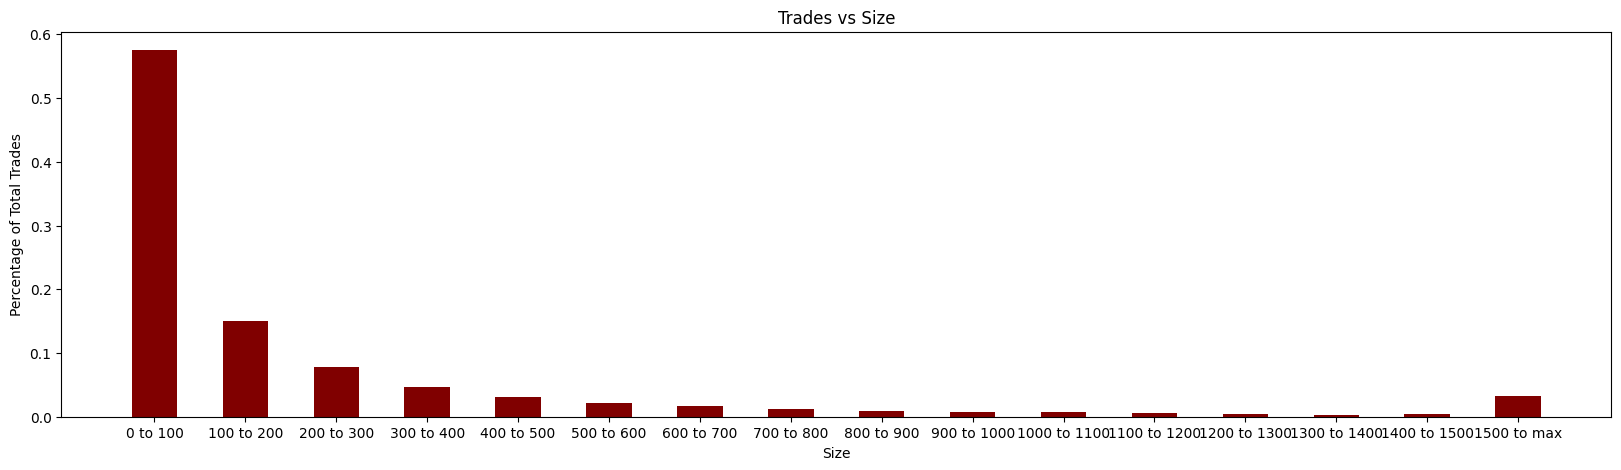

In [45]:
#max size of an order = 11823, so lets plot a histogram of size vs fillrate
fill_rate_size = np.empty(0)
percent_of_trades = np.empty(0)
x_labels = np.empty(0)
for i in np.arange(0, 1500, 100):
    temp_df = df1.loc[df["Size"] >= i]
    temp_df = temp_df.loc[temp_df["Size"] <= (i + 100)]
    fill_rate_size = np.append(fill_rate_size, temp_df["FILL"].mean())
    x_labels = np.append(x_labels, f"{i} to {i + 100}")
    percent_of_trades = np.append(percent_of_trades, len(temp_df)/len(df1))

last_df = df1.loc[df["Size"] >= 1500]
last_df = last_df.loc[last_df["Size"] <= df["Size"].max()]
fill_rate_size = np.append(fill_rate_size, last_df["FILL"].mean())
x_labels = np.append(x_labels, f"{1500} to max")
percent_of_trades = np.append(percent_of_trades, len(last_df)/len(df1))

fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(x_labels, fill_rate_size, color ='blue', width = 0.5)
plt.ylim(0, 0.5)
 
plt.xlabel("Order Size Range")
plt.ylabel("Fill Percentage")
plt.title("Fill Rate vs Size")
plt.show()

fig2 = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(x_labels, percent_of_trades, color ='maroon',
        width = 0.5)
plt.xlabel("Size")
plt.ylabel("Percentage of Total Trades")
plt.title("Trades vs Size")
plt.show()

Some stocks had higher correlations with fill rate than others,however, there wasn't anything deeply significant. I still chose to see whether some stocks produced higher fill rates overall.

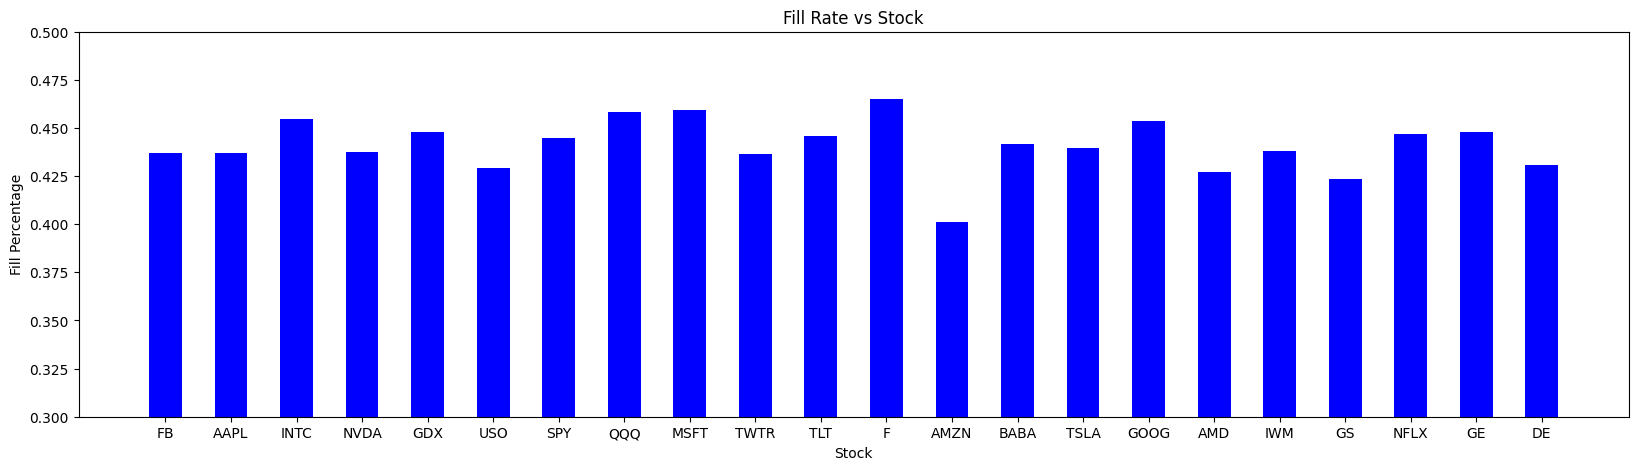

In [46]:
stocks = np.array(df.UnderlyingSymbol.unique())
fill_rate_stocks = np.empty(0)
for i in stocks:
    temp_df = df1.loc[df1[i] == 1]
    fill_rate_stocks = np.append(fill_rate_stocks, temp_df["FILL"].mean())

fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(stocks, fill_rate_stocks, color ='blue', width = 0.5)
plt.ylim(0.3, 0.5)
 
plt.xlabel("Stock")
plt.ylabel("Fill Percentage")
plt.title("Fill Rate vs Stock")
plt.show()


In [49]:
stocks = np.array(df.UnderlyingSymbol.unique())
exchange = np.array(df.Exchange.unique())
fill_rate_se = np.empty(0)
for i in exchange:
    fill_rate = np.empty(0)
    for j in stocks:
        temp_df = df1.loc[df1[i] == 1]
        temp_df = temp_df.loc[temp_df[j] == 1]
        fill_rate = np.append(fill_rate, temp_df["FILL"].mean())
    fill_rate_se = np.append(fill_rate_se, np.array(fill_rate))
fill_rate_se = fill_rate_se.reshape(len(exchange), len(stocks))
fig = px.imshow(fill_rate_se, 
                labels=dict(x="Stock", y="Exchange", color="Fill Rate"),
                x=stocks,
                y=exchange
               )
fig.update_xaxes(side="top")
fig.show()

In [54]:
stocks = np.array(df.UnderlyingSymbol.unique())
exchange = np.array(df.Exchange.unique())
numberoftrades = np.empty(0)
for i in exchange:
    x = np.empty(0)
    for j in stocks:
        temp_df = df1.loc[df1[i] == 1]
        temp_df = temp_df.loc[temp_df[j] == 1]
        x = np.append(x, len(temp_df))
    numberoftrades = np.append(numberoftrades, np.array(x))
numberoftrades = numberoftrades.reshape(len(exchange), len(stocks))

fig = px.imshow(numberoftrades, 
                labels=dict(x="Stock", y="Exchange", color="Number of Trades"),
                x=stocks,
                y=exchange
               )
fig.update_xaxes(side="top")
fig.show()

Lastly, I chose to see whether the time of day the trade was made impacted the the rate at which trades were filled. 

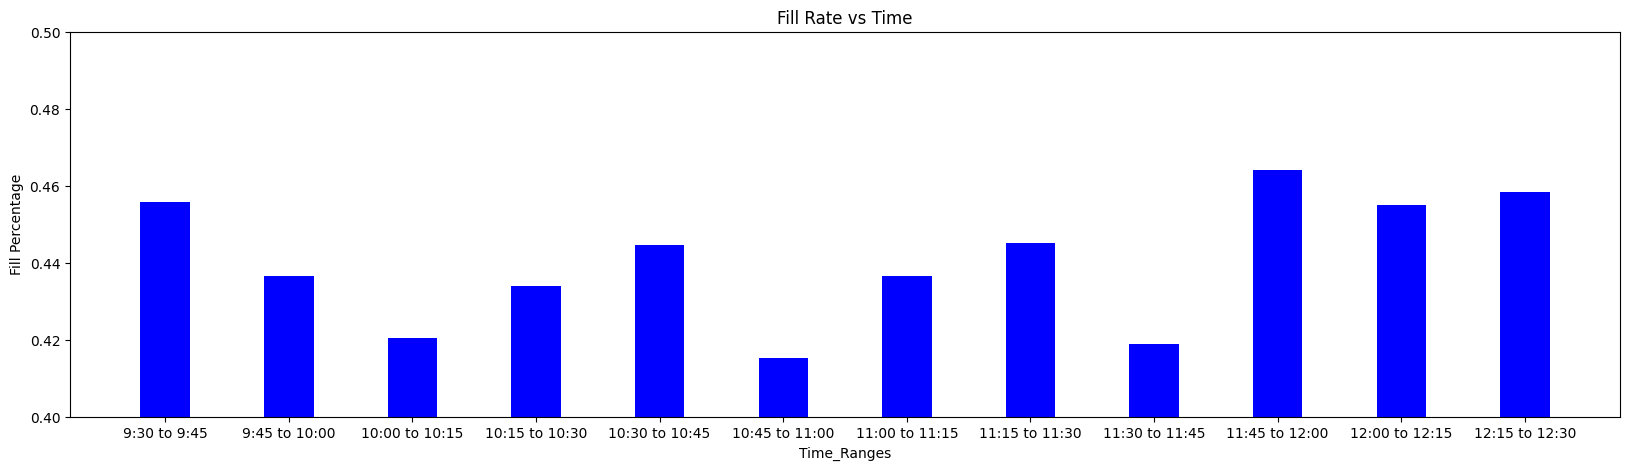

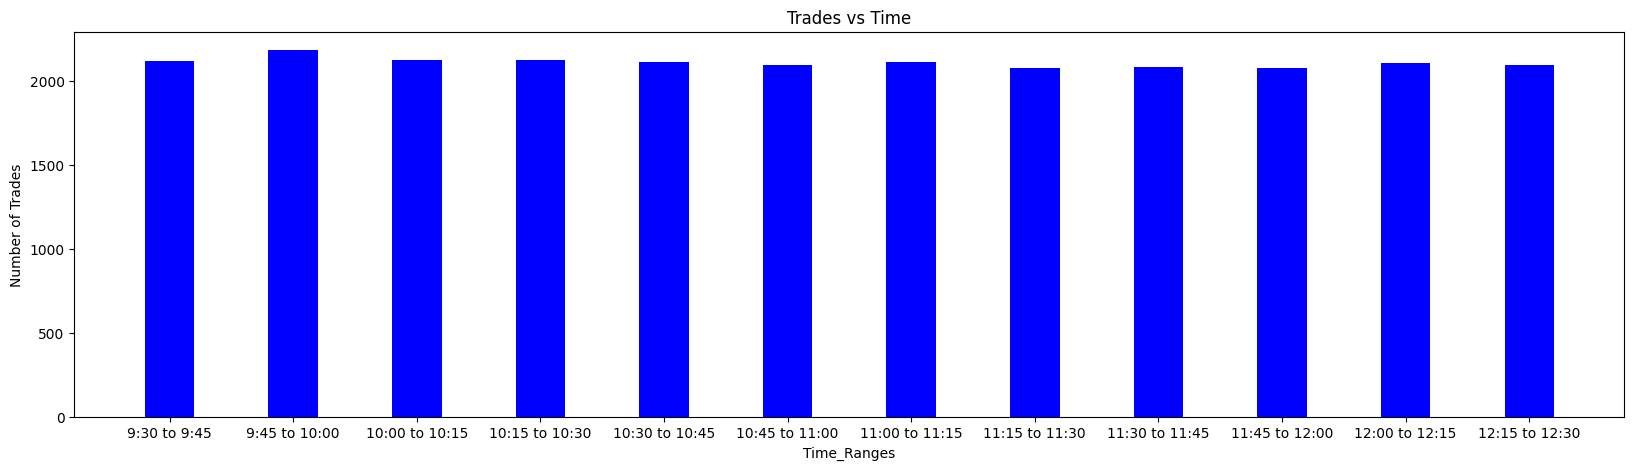

In [12]:
fill_rate_time = np.empty(0)
x = df.TimeOfOrder.unique()
time_ranges = x[0:len(x):15]
trade_count = np.empty(0)
x_time = ["9:30 to 9:45","9:45 to 10:00", "10:00 to 10:15", "10:15 to 10:30", "10:30 to 10:45","10:45 to 11:00", "11:00 to 11:15", "11:15 to 11:30", "11:30 to 11:45","11:45 to 12:00", "12:00 to 12:15", "12:15 to 12:30"]
for i in range(len(time_ranges) - 1):
    temp_df = df1.loc[df1["TimeOfOrder"] > time_ranges[i]]
    temp_df = temp_df.loc[temp_df["TimeOfOrder"] <= time_ranges[i + 1]]
    fill_rate_time = np.append(fill_rate_time, temp_df["FILL"].mean())
    trade_count = np.append(trade_count, len(temp_df))

fig = plt.figure(figsize = (20, 5))
plt.bar(x_time, fill_rate_time, color ='blue', width = 0.4)
plt.ylim(0.4, 0.5)
 
plt.xlabel("Time_Ranges")
plt.ylabel("Fill Percentage")
plt.title("Fill Rate vs Time")
plt.show()

fig2 = plt.figure(figsize = (20, 5))
plt.bar(x_time, trade_count, color ='blue', width = 0.4)
 
plt.xlabel("Time_Ranges")
plt.ylabel("Number of Trades")
plt.title("Trades vs Time")
plt.show()

In [29]:
round_number = df1.loc[df1["Strike"] % 5 == 0]
other_number = df1.loc[df1["Strike"] % 5 != 0]
print(round_number.FILL.mean(), other_number.FILL.mean())



0.42340372360364864 0.4680011548455394


## Reducing Latency

We can see from the correlaton table that the major factor affecting the time interval between the time the order manager recieves and places the order is which exchange the order is placed in. Their correlations range from 27 to 81% so I'm going to assume that is the primary source of reducing latency.

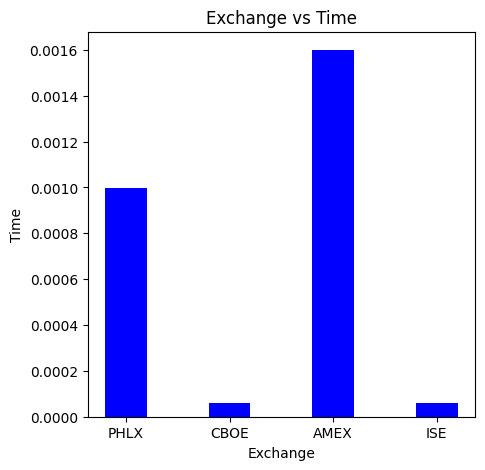

In [13]:
exchange
latency_exchange = np.empty(0)
for i in exchange:
    temp_df = df1.loc[df1[i] == 1]
    latency_exchange = np.append(latency_exchange, temp_df["Time"].mean())

fig = plt.figure(figsize = (5, 5))
plt.bar(exchange, latency_exchange, color ='blue', width = 0.4)
 
plt.xlabel("Exchange")
plt.ylabel("Time")
plt.title("Exchange vs Time")
plt.show()

In [30]:
round_number = df1.loc[df1["Strike"] % 5 == 0]
other_number = df1.loc[df1["Strike"] % 5 != 0]
print(round_number.Time.mean(), other_number.Time.mean())

0.0006866030238660603 0.0006779270522567942
